# **Reporte del Modelo Baseline**
---

In [16]:
# Librerias
!pip install optuna
import os
import requests
import logging
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
# Funcion para crear el objeto de creación de logs
def create_logger():
  logging.basicConfig(level = logging.INFO, format = '%(asctime)s - %(levenname)s - %(message)s')
  logger = logging.getLogger('Logger')
  logger.info('Logger creado')
  return logger

In [3]:
# Función de consumo a la base de datos de Firebase para cargar el DataSet
def download_firebase(url, logger):
  logger.info("Extrayendo el archivo desde Firebase")
  df = None
  try:
    df = pd.read_csv(url)
    logger.info("Archivo cargado")
  except requests.exceptions.RequestException as e:
    logger.info(f"Error al descargar el archivo CSV: {e}")
  except pd.errors.EmptyDataError:
    logger.info("El archivo CSV está vacío.")
  except Exception as e:
    logger.info(f"Ocurrió un error inesperado: {e}")
  return df

In [4]:
# Cargar DataSet
url = 'https://firebasestorage.googleapis.com/v0/b/personalwp-8822c.appspot.com/o/diabetes_prediction_dataset.csv?alt=media&token=4d70d154-c3d0-4fa0-a3aa-9b9972dd3b95'
logger = create_logger()
df = download_firebase(url, logger)

In [5]:
# Eliminación de valores atípicos y duplicados
seventy_fifth = df['bmi'].quantile(0.75)
twenty_fifth = df['bmi'].quantile(0.25)
iqr = seventy_fifth - twenty_fifth
upper = seventy_fifth + (10 * iqr)
outliers_bmi_upper = df[(df['bmi'] > upper)]
df = pd.merge(df, outliers_bmi_upper, indicator = True, how = 'outer').query('_merge == "left_only"').drop('_merge', axis = 1)
df = df.drop_duplicates(keep = "first")

In [40]:
# Variables Categóricas a Numéricas
df['gender'] = pd.factorize(df['gender'])[0]
df['smoking_history'] = pd.factorize(df['smoking_history'])[0]

## **Implementación del Modelo**

### **Partición de Datos**

In [7]:
# Separación de la 'Data' (Características)
X = df.drop(columns = 'diabetes')
X.shape

(96143, 8)

In [8]:
# Separación del 'Target' (Variable objetivo)
y = df['diabetes']
y.shape

(96143,)

In [9]:
# Partición de los datos: 70% para entrenamiento, 30% para prueba y estratificación en las etiquetas (y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [10]:
# Validación de la partición de los datos
print(f'Número de muestras en entrenamiento: {X_train.shape[0]}')
print(f'Número de muestras en prueba: {X_test.shape[0]}')
print(f'Número de características: {X_train.shape[1]}')

Número de muestras en entrenamiento: 67300
Número de muestras en prueba: 28843
Número de características: 8


In [11]:
# Distribución de la variable objetivo en los conjuntos de entrenamiento y prueba
print(f'Distribución de clases en entrenamiento: {np.bincount(y_train)}')
print(f'Distribución de clases en prueba: {np.bincount(y_test)}')

Distribución de clases en entrenamiento: [61363  5937]
Distribución de clases en prueba: [26298  2545]


### **Entrenamiento del Modelo**

In [12]:
# Función para la definición y entrenamiento de hiperparámetros a explorar
def objective(trial):
  max_depth = trial.suggest_int("max_depth", 1, 100)
  n_estimators = trial.suggest_int("n_estimators", 1, 200)
  learning_rate = trial.suggest_float("learning_rate", 1e-6, 1, log = True)
  model = XGBClassifier(max_depth = max_depth, n_estimators = n_estimators, learning_rate = learning_rate)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  score = accuracy_score(y_test, y_pred)
  return score

In [13]:
# Exploración de hiperparámetros
study = optuna.create_study(direction = "maximize", storage = "sqlite:///hp.db", study_name = "XGBClassifier")
study.optimize(func = objective, n_trials = 100, n_jobs = -1)

[I 2024-12-12 20:44:31,476] A new study created in RDB with name: XGBClassifier
[I 2024-12-12 20:44:32,348] Trial 1 finished with value: 0.9117636861630205 and parameters: {'max_depth': 35, 'n_estimators': 1, 'learning_rate': 2.7948196909157036e-06}. Best is trial 1 with value: 0.9117636861630205.
[I 2024-12-12 20:44:42,524] Trial 0 finished with value: 0.9117636861630205 and parameters: {'max_depth': 96, 'n_estimators': 175, 'learning_rate': 2.2795752495443987e-06}. Best is trial 0 with value: 0.9117636861630205.
[I 2024-12-12 20:44:44,141] Trial 2 finished with value: 0.9665430087022848 and parameters: {'max_depth': 66, 'n_estimators': 169, 'learning_rate': 0.06977620265091686}. Best is trial 2 with value: 0.9665430087022848.
[I 2024-12-12 20:44:48,589] Trial 4 finished with value: 0.9710848386090213 and parameters: {'max_depth': 10, 'n_estimators': 169, 'learning_rate': 0.0635014610438432}. Best is trial 4 with value: 0.9710848386090213.
[I 2024-12-12 20:44:53,402] Trial 3 finished 

In [14]:
# Mejor hiperparámetro
params = study.best_params
print(params)

{'max_depth': 1, 'n_estimators': 158, 'learning_rate': 0.7161486885849615}


In [15]:
# Mejor metrica
score = study.best_value
print(score)

0.9716395659258745


In [18]:
# Entrenamiento del mejor modelo
model_XGBC = XGBClassifier(max_depth = 48, n_estimators = 130, learning_rate = 0.010291737939302062).fit(X_train, y_train)

In [37]:
# Metricas de desempeño
XGBC_prediction = model_XGBC.predict(X_test)
XGBC_acc = accuracy_score(y_test, XGBC_prediction) * 100
XGBC_pre_0 = precision_score(y_test, XGBC_prediction, pos_label = 0) * 100
XGBC_pre_1 = precision_score(y_test, XGBC_prediction, pos_label = 1) * 100
XGBC_rec_0 = recall_score(y_test, XGBC_prediction, pos_label = 0) * 100
XGBC_rec_1 = recall_score(y_test, XGBC_prediction, pos_label = 1) * 100
XGBC_f1s_0 = f1_score(y_test, XGBC_prediction, pos_label = 0) * 100
XGBC_f1s_1 = f1_score(y_test, XGBC_prediction, pos_label = 1) * 100
columns = ["Métricas", "Porcentaje_0", "Porcentaje_1"]
data = [["Precision", XGBC_pre_0, XGBC_pre_1], ["Recall", XGBC_rec_0, XGBC_rec_1], ["F1-score", XGBC_f1s_0, XGBC_f1s_1]]
metrics = pd.DataFrame(data, columns = columns)
metrics

,Métricas,Porcentaje_0,Porcentaje_1
0,Precision,96.978194,99.195402
1,Recall,99.946764,67.819253
2,F1-score,98.440104,80.560093


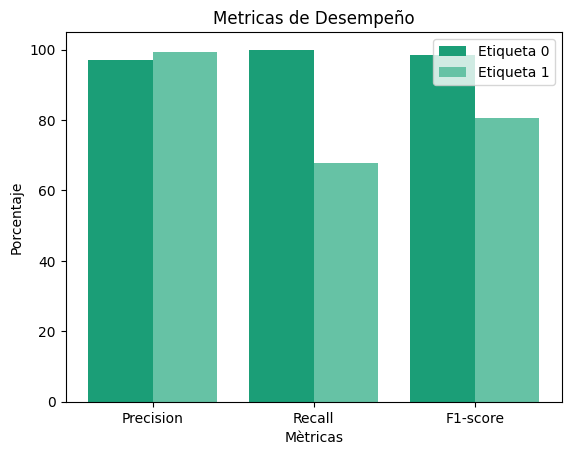

In [39]:
# Histograma de Accuracy
plt.title('Metricas de Desempeño')
plt.xlabel("Mètricas")
plt.ylabel("Porcentaje")
x = np.arange(len(metrics['Métricas']))
plt.bar(x, metrics['Porcentaje_0'], width = 0.4, label = 'Etiqueta 0', color = "#1B9E77")
plt.bar(x + 0.4, metrics['Porcentaje_1'], width = 0.4, label = 'Etiqueta 1', color = "#66C2A5")
plt.xticks(x + 0.2, ["Precision", "Recall", "F1-score"])
plt.legend()
plt.savefig("xgb_model_metrics.jpg")
plt.show()

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*